# Running the Supervised Optimizer

From start to finish, on pretrained weights


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import os
from Ising import Ising
from model import TransformerModel
from optimizer_supervised_batches import Optimizer

In [3]:
def gpu_setup():
    # Setup for PyTorch:
    if torch.cuda.is_available():
        torch_device = torch.device("cuda")
        print("PyTorch is using GPU {}".format(torch.cuda.current_device()))
    else:
        torch_device = torch.device("cpu")
        print("GPU unavailable; using CPU")

In [4]:
!nvidia-smi

Thu Aug  1 13:11:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0  On |                  N/A |
|  0%   41C    P5              28W / 350W |   3621MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
gpu_setup()

PyTorch is using GPU 0


In [6]:
torch.set_default_device("cuda")
torch.set_default_dtype(torch.float32)

In [7]:
import plotly.graph_objects as go
import numpy as np


def plot_tensor(tens, labels, opacity=0.7, size=5):

    x = np.arange(tens.shape[0])
    y = np.arange(tens.shape[1])
    z = np.arange(tens.shape[2])

    xlen = len(x)
    ylen = len(y)
    zlen = len(z)

    print(f"(x, y, z) = ({xlen}, {ylen}, {zlen})")

    X, Y, Z = np.meshgrid(x, y, z)

    color_function = np.vectorize(lambda x, y, z: tens[x, y, z])

    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=X.flatten(),
                y=Y.flatten(),
                z=Z.flatten(),
                mode="markers",
                marker=dict(
                    size=size,
                    # color=tens.swapaxes(1, 2)
                    # .swapaxes(0, 2)
                    # .swapaxes(1, 2)
                    # .flatten(),  # set color to an array/list of desired values
                    color=color_function(X, Y, Z).flatten(),
                    colorscale="bupu",  # choose a colorscale
                    opacity=opacity,
                ),
            )
        ]
    )

    fig.update_layout(
        scene=dict(xaxis_title=labels[0], yaxis_title=labels[1], zaxis_title=labels[2]),
    )
    fig.show()

## New Probabilistic Batched Method


In [8]:
system_sizes = torch.arange(15, 15 + 2, 2).reshape(-1, 1)
Hamiltonians = [Ising(size, periodic=True, get_basis=True) for size in system_sizes]
param_dim = Hamiltonians[0].param_dim
embedding_size = 32
n_head = 8
n_hid = embedding_size
n_layers = 8
dropout = 0
minibatch = 10000
param_range = None
point_of_interest = None
use_SR = False

print("Sizes:\n", system_sizes)
print("Dimensions of parameter space:", param_dim)
print("Number of units in a feedforward layer:", n_hid)

/home/spandan/anaconda3/envs/tqs2/lib/python3.12/site-packages/torch/utils/_device.py:78: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1718580740865/work/aten/src/ATen/native/TensorShape.cpp:3675.)
  return func(*args, **kwargs)
/home/spandan/anaconda3/envs/tqs2/lib/python3.12/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Sizes:
 tensor([[15]], device='cuda:0')
Dimensions of parameter space: 1
Number of units in a feedforward layer: 32


In [9]:
import math

gaussian_coeff = 1 / math.sqrt(2 * math.pi)
gaussian_mean = 1.0
gaussian_std = 0.05
probability_distribution = lambda param: gaussian_coeff * torch.exp(
    -0.5 * (((param - gaussian_mean) ** 2) / gaussian_std**2)
)

In [10]:
# data_dir_path = os.path.join("TFIM_ground_states", "2024-07-24T19-26-39.836")
# data_dir_path = os.path.join("TFIM_ground_states", "2024-07-24T16-19-00.994")

data_dir_path = os.path.join("TFIM_ground_states", "2024-08-01T12-15-57.529")

for ham in Hamiltonians:
    ham.load_dataset(
        data_dir_path,
        batch_size=30000,
        samples_in_epoch=100,
        sampling_type="shuffled",
    )
    # ham.training_dataset.set_sampling_distribution(probability_distribution)

print("Hamiltonians:", Hamiltonians)

Loaded dataset for system size 15 from TFIM_ground_states/2024-08-01T12-15-57.529/15.arrow.
(h_min, h_step, h_max) = (0.9, 0.01, 1.1).
Hamiltonians: [<Ising.Ising object at 0x7c94e4080ec0>]


/home/spandan/anaconda3/envs/tqs2/lib/python3.12/site-packages/torch/utils/_device.py:78: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1718580740865/work/torch/csrc/utils/tensor_new.cpp:274.)
  return func(*args, **kwargs)


In [28]:
2**15

32768

In [11]:
Hamiltonians[0].dataset

,N,h,energy,state
0,15,0.90,-18.254842,"[-0.4058973302852654, -0.09786162073891716, -0..."
1,15,0.91,-18.335790,"[-0.39715955046983503, -0.09705792787578245, -..."
2,15,0.92,-18.418227,"[-0.3882020093591566, -0.09615672061686589, -0..."
3,15,0.93,-18.502182,"[0.3790374665105676, 0.09515828493805044, 0.09..."
4,15,0.94,-18.587675,"[0.3696836003675336, 0.09406415374876126, 0.09..."
5,15,0.95,-18.674725,"[0.36016315541068883, 0.09287722496805598, 0.0..."
6,15,0.96,-18.763344,"[-0.3505037986198456, -0.09160182480784362, -0..."
7,15,0.97,-18.853538,"[-0.34073772336822944, -0.09024370469340201, -..."
8,15,0.98,-18.945309,"[0.3309009675330086, 0.08880996813032249, 0.08..."
9,15,0.99,-19.038649,"[-0.32103248674263424, -0.08730891787130068, -..."


In [12]:
testmodel = TransformerModel(
    system_sizes,
    param_dim,
    embedding_size,
    n_head,
    n_hid,
    n_layers,
    dropout=dropout,
    minibatch=minibatch,
)

results_dir = "results"
paper_checkpoint_name = "ckpt_100000_Ising_32_8_8_0.ckpt"
paper_checkpoint_path = os.path.join(results_dir, paper_checkpoint_name)
checkpoint = torch.load(paper_checkpoint_path)
testmodel.load_state_dict(checkpoint)

/home/spandan/anaconda3/envs/tqs2/lib/python3.12/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/spandan/anaconda3/envs/tqs2/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [13]:
testmodel.cuda()

TransformerModel(
  (pos_encoder): TQSPositionalEncoding1D(
    (dropout): Dropout(p=0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=32, out_features=32, bias=True)
          (linear_Q): Linear(in_features=32, out_features=32, bias=True)
          (linear_K): Linear(in_features=32, out_features=32, bias=True)
          (linear_V): Linear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=32, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=32, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
    )


In [14]:
opt = Optimizer(testmodel, Hamiltonians, point_of_interest=point_of_interest)

In [15]:
drmg40path = os.path.join("results", "E_dmrg_40.npy")
dmrg40 = np.load(drmg40path)
ising40 = Ising(
    torch.tensor([40]),
    periodic=False,
    get_basis=False,
)
dmrg40_h_values = np.linspace(0, 2, 101)
oneidx = np.where(dmrg40_h_values == 1.0)[0][0]

/home/spandan/anaconda3/envs/tqs2/lib/python3.12/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


In [16]:
opt.train(
    epochs=3,
    start_iter=0,
    monitor_params=torch.tensor([[1.0]]),
    monitor_hamiltonians=[ising40],
    monitor_energies=torch.tensor([[dmrg40[oneidx]]]),
)

/home/spandan/anaconda3/envs/tqs2/lib/python3.12/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch 0 iter 0 - Loss for system size tensor([15], device='cuda:0') and h-range 0.9-1.1: 0.06509923934936523
E_mean tensor(-50.5804+0.0018j, device='cuda:0') E_ground tensor([-50.5694], device='cuda:0', dtype=torch.float64) param tensor([1.], device='cuda:0')
	param=tensor([1.], device='cuda:0'), system_size=tensor([40], device='cuda:0') - Relative Error: tensor([0.0002], device='cuda:0', dtype=torch.float64)
		Energy: (-50.580406188964844+0.0017780950292944908j), Variance: 2.522479690014734e-06, Real: -1.264510154724121, Imag: 4.445237573236227e-05
Time breakdown: psi: 0.49486351013183594, loss: 0.012964725494384766, backprop: 0.5389039516448975, energy retrieval: 0.4910619258880615
Epoch 0 iter 1 - Loss for system size tensor([15], device='cuda:0') and h-range 0.9-1.1: 0.06489420682191849
E_mean tensor(-50.5933+0.0036j, device='cuda:0') E_ground tensor([-50.5694], device='cuda:0', dtype=torch.float64) param tensor([1.], device='cuda:0')
	param=tensor([1.], device='cuda:0'), system_si

In [17]:
errors1 = torch.tensor(opt.E_errors_all)
errors1

tensor([[2.1981e-04, 4.7800e-04, 3.7682e-05, 5.0836e-05, 2.0768e-04, 3.0110e-04,
         1.3486e-04, 3.5630e-04, 2.1922e-04, 1.0505e-04, 4.4765e-05, 1.3904e-04,
         2.8750e-04, 3.2383e-04, 3.0051e-04, 6.6479e-04, 6.0782e-04, 2.1738e-04,
         1.2065e-04, 6.9874e-05, 3.8691e-04, 1.7447e-04, 4.4916e-04],
        [3.2744e-04, 3.9943e-04, 3.0129e-04, 3.3041e-04, 1.0481e-04, 3.7583e-04,
         2.1674e-04, 1.4579e-04, 1.5211e-04, 7.0103e-04, 1.5023e-04, 2.9099e-04,
         4.4058e-04, 4.3080e-04, 2.5292e-04, 1.2862e-04, 2.1828e-04, 1.7565e-04,
         1.8194e-04, 4.8612e-04, 2.8089e-04, 1.5035e-04, 3.5629e-04],
        [6.1485e-04, 2.4161e-04, 2.3360e-04, 3.4231e-04, 3.8632e-04, 1.1091e-04,
         2.0848e-04, 2.5359e-04, 2.6364e-04, 2.5982e-04, 5.4301e-04, 2.8964e-04,
         5.4097e-04, 2.8656e-04, 2.2161e-04, 1.2942e-04, 3.7122e-04, 2.8039e-04,
         7.5061e-04, 2.0445e-04, 1.1658e-04, 5.2011e-04, 4.1810e-04]],
       device='cuda:0', dtype=torch.float64)

In [18]:
opt.train(
    epochs=3,
    start_iter=0,
    monitor_params=torch.tensor([[1.0]]),
    monitor_hamiltonians=[ising40],
    monitor_energies=torch.tensor([[dmrg40[oneidx]]]),
)

Epoch 0 iter 0 - Loss for system size tensor([15], device='cuda:0') and h-range 0.9-1.1: 0.05060538277029991
E_mean tensor(-50.5617+0.0057j, device='cuda:0') E_ground tensor([-50.5694], device='cuda:0', dtype=torch.float64) param tensor([1.], device='cuda:0')
	param=tensor([1.], device='cuda:0'), system_size=tensor([40], device='cuda:0') - Relative Error: tensor([0.0002], device='cuda:0', dtype=torch.float64)
		Energy: (-50.561668395996094+0.005680050700902939j), Variance: 7.28207987776841e-06, Real: -1.2640416622161865, Imag: 0.00014200127043295652
Time breakdown: psi: 0.004005908966064453, loss: 0.00018525123596191406, backprop: 0.7620415687561035, energy retrieval: 0.45401787757873535
Epoch 0 iter 1 - Loss for system size tensor([15], device='cuda:0') and h-range 0.9-1.1: 0.050554610788822174
E_mean tensor(-50.5883+0.0022j, device='cuda:0') E_ground tensor([-50.5694], device='cuda:0', dtype=torch.float64) param tensor([1.], device='cuda:0')
	param=tensor([1.], device='cuda:0'), syst

In [19]:
errors2 = torch.tensor(opt.E_errors_all)
errors2

tensor([[1.9025e-04, 3.7532e-04, 6.7416e-04, 1.6224e-04, 7.6676e-04, 1.3602e-04,
         3.9794e-04, 2.5694e-04, 5.0849e-04, 8.9629e-04, 2.5266e-04, 4.8803e-04,
         3.9836e-04, 3.4005e-04, 5.4406e-04, 2.3192e-04, 6.7004e-04, 4.8587e-04,
         4.2450e-04, 3.6866e-04, 2.7645e-04, 9.6553e-04, 2.3307e-05],
        [1.0868e-04, 6.5997e-04, 7.4257e-04, 1.4457e-04, 9.7167e-05, 4.8556e-04,
         5.0179e-04, 8.9268e-04, 5.3901e-04, 2.7247e-04, 5.6565e-04, 2.8542e-04,
         5.0936e-04, 7.7731e-04, 2.2713e-04, 2.2200e-04, 6.6324e-04, 2.7919e-04,
         1.5824e-04, 2.4281e-04, 2.1139e-04, 3.4592e-04, 8.7644e-04],
        [1.0944e-04, 3.0056e-04, 6.7753e-04, 6.9583e-04, 1.0375e-03, 1.4651e-04,
         7.8162e-04, 7.0936e-04, 6.5497e-04, 2.4691e-04, 8.2336e-04, 1.2266e-03,
         4.2642e-04, 5.5866e-04, 8.7237e-04, 1.2290e-03, 9.6427e-04, 4.0741e-04,
         5.0125e-04, 1.5489e-03, 2.0059e-03, 7.8141e-04, 1.0165e-03]],
       device='cuda:0', dtype=torch.float64)

In [20]:
opt.train(
    epochs=3,
    start_iter=0,
    monitor_params=torch.tensor([[1.0]]),
    monitor_hamiltonians=[ising40],
    monitor_energies=torch.tensor([[dmrg40[oneidx]]]),
)

Epoch 0 iter 0 - Loss for system size tensor([15], device='cuda:0') and h-range 0.9-1.1: 0.04473361372947693
E_mean tensor(-50.5603+0.0014j, device='cuda:0') E_ground tensor([-50.5694], device='cuda:0', dtype=torch.float64) param tensor([1.], device='cuda:0')
	param=tensor([1.], device='cuda:0'), system_size=tensor([40], device='cuda:0') - Relative Error: tensor([0.0002], device='cuda:0', dtype=torch.float64)
		Energy: (-50.560279846191406+0.001355799613520503j), Variance: 3.293943882454187e-05, Real: -1.2640069723129272, Imag: 3.3894990338012576e-05
Time breakdown: psi: 0.0040132999420166016, loss: 0.0001590251922607422, backprop: 0.7678852081298828, energy retrieval: 0.4573240280151367
Epoch 0 iter 1 - Loss for system size tensor([15], device='cuda:0') and h-range 0.9-1.1: 0.04494527727365494
E_mean tensor(-50.6022+0.0086j, device='cuda:0') E_ground tensor([-50.5694], device='cuda:0', dtype=torch.float64) param tensor([1.], device='cuda:0')
	param=tensor([1.], device='cuda:0'), syste

In [22]:
errors3 = torch.tensor(opt.E_errors_all)
errors3

tensor([[0.0002, 0.0007, 0.0007, 0.0005, 0.0024, 0.0003, 0.0006, 0.0007, 0.0002,
         0.0025, 0.0015, 0.0006, 0.0014, 0.0007, 0.0001, 0.0006, 0.0010, 0.0006,
         0.0002, 0.0002, 0.0014, 0.0011, 0.0014],
        [0.0004, 0.0010, 0.0011, 0.0018, 0.0009, 0.0003, 0.0004, 0.0015, 0.0007,
         0.0023, 0.0023, 0.0011, 0.0004, 0.0007, 0.0014, 0.0015, 0.0010, 0.0003,
         0.0004, 0.0018, 0.0008, 0.0005, 0.0006],
        [0.0027, 0.0016, 0.0031, 0.0026, 0.0012, 0.0012, 0.0007, 0.0008, 0.0006,
         0.0002, 0.0035, 0.0008, 0.0049, 0.0017, 0.0021, 0.0023, 0.0007, 0.0003,
         0.0009, 0.0061, 0.0021, 0.0027, 0.0015]], device='cuda:0',
       dtype=torch.float64)

In [27]:
errors3.shape

torch.Size([3, 23])

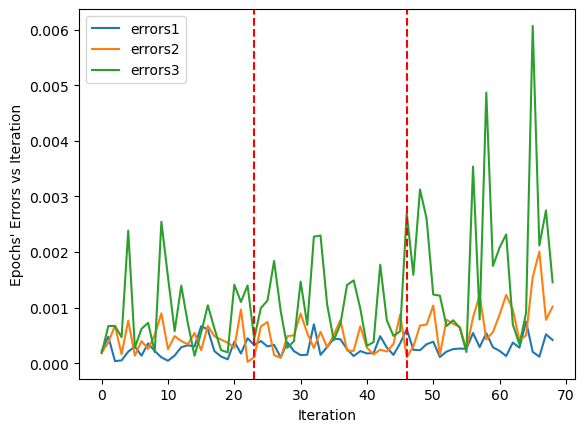

In [31]:
import matplotlib.pyplot as plt

plt.plot(errors1.flatten().cpu().numpy(), label="errors1")
plt.plot(errors2.flatten().cpu().numpy(), label="errors2")
plt.plot(errors3.flatten().cpu().numpy(), label="errors3")
plt.xlabel("Iteration")
plt.ylabel("Epochs' Errors vs Iteration")
plt.legend()

for i in range(1, 3):
    plt.axvline(x=i * errors1.shape[1], color="r", linestyle="--")

plt.show()

In [37]:
errors = torch.stack([errors1, errors2, errors3], dim=0)

In [38]:
errors

tensor([[[2.1981e-04, 4.7800e-04, 3.7682e-05, 5.0836e-05, 2.0768e-04,
          3.0110e-04, 1.3486e-04, 3.5630e-04, 2.1922e-04, 1.0505e-04,
          4.4765e-05, 1.3904e-04, 2.8750e-04, 3.2383e-04, 3.0051e-04,
          6.6479e-04, 6.0782e-04, 2.1738e-04, 1.2065e-04, 6.9874e-05,
          3.8691e-04, 1.7447e-04, 4.4916e-04],
         [3.2744e-04, 3.9943e-04, 3.0129e-04, 3.3041e-04, 1.0481e-04,
          3.7583e-04, 2.1674e-04, 1.4579e-04, 1.5211e-04, 7.0103e-04,
          1.5023e-04, 2.9099e-04, 4.4058e-04, 4.3080e-04, 2.5292e-04,
          1.2862e-04, 2.1828e-04, 1.7565e-04, 1.8194e-04, 4.8612e-04,
          2.8089e-04, 1.5035e-04, 3.5629e-04],
         [6.1485e-04, 2.4161e-04, 2.3360e-04, 3.4231e-04, 3.8632e-04,
          1.1091e-04, 2.0848e-04, 2.5359e-04, 2.6364e-04, 2.5982e-04,
          5.4301e-04, 2.8964e-04, 5.4097e-04, 2.8656e-04, 2.2161e-04,
          1.2942e-04, 3.7122e-04, 2.8039e-04, 7.5061e-04, 2.0445e-04,
          1.1658e-04, 5.2011e-04, 4.1810e-04]],

        [[1.9025e

In [43]:
plot_tensor(errors.cpu(), ["3-Epoch", "Epoch", "Iteration"])

(x, y, z) = (3, 3, 23)


In [ ]:
plot_tensor(errors1.cpu().unsqueeze(1), ["Epoch", "Iteration", "Error"])

In [ ]:
plot_tensor(
    Hamiltonians[0].training_dataset.sampled.unsqueeze(1).cpu().numpy(),
    ["batch", "system size", "parameter"],
    opacity=0.5,
    size=3,
)

(x, y, z) = (101, 1, 16)


# Old Non-Batched Method


In [ ]:
system_sizes = torch.arange(2, 16 + 1, 2).reshape(-1, 1)
Hamiltonians = [Ising(size, periodic=True) for size in system_sizes]
param_dim = Hamiltonians[0].param_dim
embedding_size = 32
n_head = 8
n_hid = embedding_size
n_layers = 8
dropout = 0
minibatch = 1000
param_range = None
point_of_interest = None
use_SR = False

Hamiltonians = [Ising(L) for L in system_sizes]
data_dir_path = os.path.join("TFIM_ground_states", "2024-07-24T19-26-39.836")
for ham in Hamiltonians:
    ham.load_dataset(data_dir_path)

print("Sizes:\n", system_sizes)
print("Hamiltonians:", Hamiltonians)
print("Dimensions of parameter space:", param_dim)
print("Number of units in a feedforward layer:", n_hid)

/home/spandan/anaconda3/envs/tqs2/lib/python3.12/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


KeyboardInterrupt: 

In [ ]:
testmodel = TransformerModel(
    system_sizes,
    param_dim,
    embedding_size,
    n_head,
    n_hid,
    n_layers,
    dropout=dropout,
    minibatch=minibatch,
)

results_dir = "results"
paper_checkpoint_name = "ckpt_100000_Ising_32_8_8_0.ckpt"
paper_checkpoint_path = os.path.join(results_dir, paper_checkpoint_name)
checkpoint = torch.load(paper_checkpoint_path)
testmodel.load_state_dict(checkpoint)

/home/spandan/anaconda3/envs/tqs2/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [ ]:
testmodel.cuda()

TransformerModel(
  (pos_encoder): TQSPositionalEncoding1D(
    (dropout): Dropout(p=0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=32, out_features=32, bias=True)
          (linear_Q): Linear(in_features=32, out_features=32, bias=True)
          (linear_K): Linear(in_features=32, out_features=32, bias=True)
          (linear_V): Linear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=32, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=32, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
    )


In [ ]:
opt = Optimizer(testmodel, Hamiltonians, point_of_interest=point_of_interest)

/home/spandan/anaconda3/envs/tqs2/lib/python3.12/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/spandan/Projects/tqs/model.py:228: SyntaxWarning: invalid escape sequence '\p'
  """


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
import cProfile
import pstats

In [ ]:
epochs = 3
param_range = torch.tensor([[0.5, 1.5]])
param_step = torch.tensor([0.01])

In [ ]:
testmodel.minibatch = 1000

In [ ]:
# with cProfile.Profile() as pr:
# with torch.autograd.profiler.profile(use_cuda=True) as prof:
opt.train(epochs=epochs, param_range=param_range, param_step=param_step, start_iter=0)

Ran forward for tensor([2], device='cuda:0') spins at point (0.5,)
Ran forward for tensor([2], device='cuda:0') spins at point (0.5099999997764826,)
Ran forward for tensor([2], device='cuda:0') spins at point (0.5199999995529652,)
Ran forward for tensor([2], device='cuda:0') spins at point (0.5299999993294477,)
Ran forward for tensor([2], device='cuda:0') spins at point (0.5399999991059303,)
Ran forward for tensor([2], device='cuda:0') spins at point (0.5499999988824129,)
Ran forward for tensor([2], device='cuda:0') spins at point (0.5599999986588955,)
Ran forward for tensor([2], device='cuda:0') spins at point (0.5699999984353781,)
Ran forward for tensor([2], device='cuda:0') spins at point (0.5799999982118607,)
Ran forward for tensor([2], device='cuda:0') spins at point (0.5899999979883432,)
Ran forward for tensor([2], device='cuda:0') spins at point (0.5999999977648258,)
Ran forward for tensor([2], device='cuda:0') spins at point (0.6099999975413084,)
Ran forward for tensor([2], dev

/home/spandan/Projects/tqs/model.py:228: SyntaxWarning: invalid escape sequence '\p'
  """


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 